In [1]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

from src import BarrierMethod

import pandas as pd
import numpy as np
import ffn  # Download data
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = (12, 2)
import seaborn as sns

import itertools
# from tqdm import tqdm
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy import stats
import seaborn as sns
sns.set(style="ticks", palette="tab10")

# Data

[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'spy'}, xlabel='Date'>

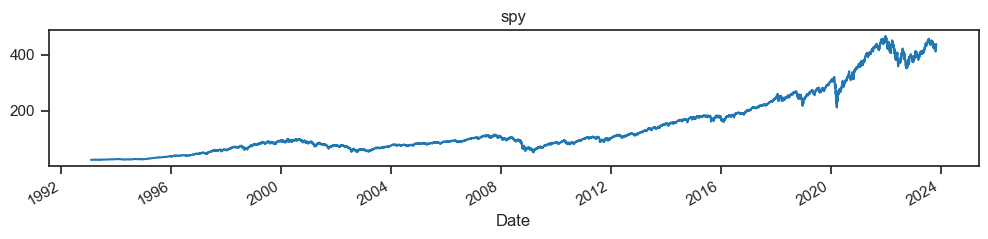

In [2]:
ticker = "spy"

data = ffn.get(ticker)[ticker]
rets = data.pct_change()

data.plot(title=ticker)

# Calculate Barriers

In [3]:
n_range = range(1, 255)
n_barriers = [2]  # I leave the possibility to check for more barriers
barriers = np.linspace(0.0 , 0.25, 501)
center = False

combinations = list(itertools.product(*[barriers, n_barriers]))
combinations = [{'barrier': i[0], 'n_barriers': i[1]} for i in combinations]

In [4]:
%%time
def process_barrier(barrier, n_barriers):
    barrier_method = BarrierMethod(returns=rets, n=max(n_range), barrier=barrier, n_barriers=n_barriers, center=center)
    _barrier_crossing = barrier_method._check_barrier_crossing()
    result = []
    for n in n_range:
        barrier_crossing = _barrier_crossing.copy()
        try:
            barrier_crossing[barrier_crossing > n] = np.nan
            barrier_crossing = barrier_method._remove_double_barrier_crossings(barrier_crossing)
            labels = barrier_method._identify_barrier_hit(barrier_crossing)
            labels = labels.dropna()
        
            if labels.nunique() == 2*n_barriers + 1:
                test_metrics = {}
                for distribution in ["norm", "uniform"]:
                    test_metrics[distribution] = stats.kstest(labels, distribution).statistic
                counts = labels.value_counts(normalize=True)
                test_metrics["diff_min_max"] = counts.max() - counts.min()
                
                signals_pa = (labels != labels.shift()).dropna().sum() / labels.dropna().shape[0] * 252
    
                result.append({
                    "n": n, 
                    "barrier": barrier, 
                    "n_barriers": n_barriers, 
                    "signals_pa": signals_pa,
                    **test_metrics
                })
        except Exception as e:
            continue
    return pd.DataFrame(result)

study = Parallel(n_jobs=-1)(delayed(process_barrier)(**kwargs) for kwargs in tqdm(combinations))
study = pd.concat(study).reset_index(drop=True)
study["barrier"] = study["barrier"].round(6)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [07:28<00:00,  1.12it/s]


CPU times: total: 2.44 s
Wall time: 7min 39s


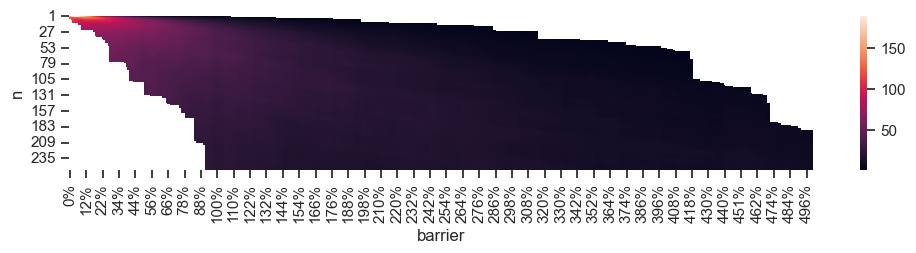

In [5]:
fig, ax = plt.subplots()
fig = sns.heatmap(study.pivot(columns="barrier", index="n", values="signals_pa"), annot=False, ax=ax)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

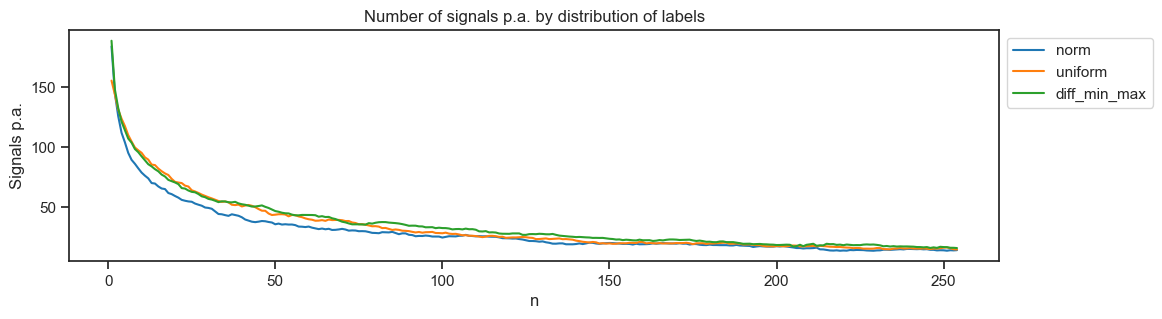

In [6]:
fig, ax = plt.subplots(figsize=(12,3))
plt.title("Number of signals p.a. by distribution of labels")
for subset in ["norm", "uniform", "diff_min_max"]:
    study_subset = study.loc[study.groupby(["n", "n_barriers"])[subset].idxmin()]
    study_subset.plot(x="n", y="signals_pa", label=subset, ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel('Signals p.a.')
plt.show()

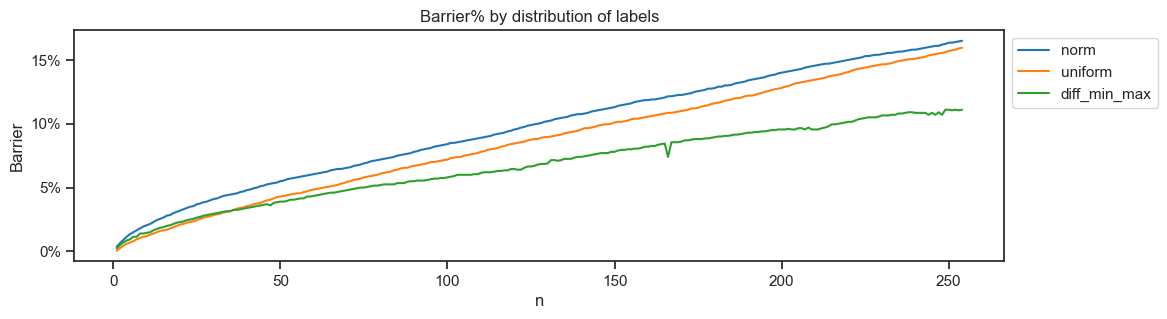

In [7]:
fig, ax = plt.subplots(figsize=(12,3))
plt.title("Barrier% by distribution of labels")
for subset in ["norm", "uniform", "diff_min_max"]:
    study_subset = study.loc[study.groupby(["n", "n_barriers"])[subset].idxmin()]
    study_subset.plot(x="n", y="barrier", label=subset, ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.ylabel('Barrier')
plt.show()

In [8]:
recommendations = []
for subset in ["norm", "uniform", "diff_min_max"]:
    study_subset = study.loc[study.groupby(["n", "n_barriers"])[subset].idxmin()]
    study_subset["selection"] = subset
    study_subset["value"] = study_subset[subset]
    study_subset = study_subset.drop(["norm", "uniform", "diff_min_max"], axis=1)
    recommendations.append(study_subset)
recommendations = pd.concat(recommendations)

In [9]:
# On average, 1 signal every 1-2 week
max_signals_pa = 52 
min_signals_pa = 26
selected_recommendations = (recommendations.query("@min_signals_pa <= signals_pa <= @max_signals_pa")
 .groupby('selection')
 .apply(lambda x: x[x['value'] == x['value'].min()])
 .set_index("selection")
 .groupby('selection').min() # Duplicates
)
selected_recommendations

,n,barrier,n_barriers,signals_pa,value
selection,,,,,
diff_min_max,41,0.0345,2,51.805229,0.160219
norm,27,0.0385,2,51.872465,0.225187
uniform,50,0.0430,2,29.113127,0.500000


array([<Axes: title={'center': 'diff_min_max'}>,
       <Axes: title={'center': 'norm'}>,
       <Axes: title={'center': 'uniform'}>], dtype=object)

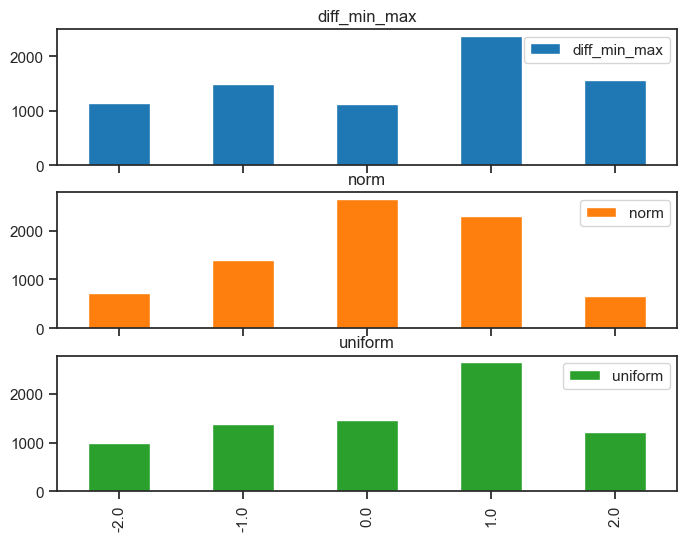

In [10]:
barrier_method_kwargs = selected_recommendations[["n", "barrier", "n_barriers"]].T.to_dict("dict")
barrier_methods = {}
for dist, kwargs in barrier_method_kwargs.items():
    barrier_methods[dist] = BarrierMethod(returns=rets, center=center, **kwargs)
    
pd.DataFrame({k: v.labels.value_counts() for k,v in barrier_methods.items()}).plot.bar(subplots=True, figsize=(8,6))